In [ ]:
pip install optuna[visualization]

In [ ]:
def choose_market_type():
    market_types = [
        "Standard Market",
        "High Volatility Market",
        "Bull Market",
        "Bear Market",
        "Sideways Market"
    ]

    print("Which trading environment do you want to use?\n Enter the corresponding number.")
    for i, mtype in enumerate(market_types):
        print(f"{i+1}: {mtype}")
    choice= input("Your choice: ")
    if choice=='1':
      print("standard")
      return None
    else:
      print (market_types[int(choice)-1])
      return market_types[int(choice)-1]

market_condition= choose_market_type()

Which trading environment do you want to use?
 Enter the corresponding number.
1: Standard Market
2: High Volatility Market
3: Bull Market
4: Bear Market
5: Sideways Market
Your choice: 1
standard


In [ ]:
import numpy as np
import gymnasium as gym
from enum import Enum

class Actions(Enum):
    Hold = 0
    Sell = -1
    Buy = 1

class Positions(Enum):
    Short = -1
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

class CryptoEnv4(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 3}

    def __init__(
        self,
        df,
        window_size,
        frame_bound,
        initial_amount=100000,
        render_mode=None,
        market_condition=None,
        profit_weight=300,
        volatility_weight=0.1,
        drawdown_weight=0.1,
        trade_penalty_weight=0.0005,
        reward_up_limit=30,
        reward_low_limit=-30,
        risk_percentage=0.05,
        stop_loss=0.05
    ):
        super().__init__()
        self.df = df
        self.window_size = window_size
        self.frame_bound = frame_bound
        self.initial_amount = initial_amount
        self.render_mode = render_mode
        self.trade_fee_percent = 0.0015
        self.market_condition = market_condition
        self.profit_weight = profit_weight
        self.volatility_weight = volatility_weight
        self.drawdown_weight = drawdown_weight
        self.trade_penalty_weight = trade_penalty_weight
        self.reward_up_limit = reward_up_limit
        self.reward_low_limit = reward_low_limit
        self.risk_percentage = risk_percentage
        self.stop_loss = stop_loss

        self._init_data()
        self._init_spaces()

        self.action_map = {
            0: Actions.Hold.value,
            1: Actions.Sell.value,
            2: Actions.Buy.value,
        }
        self.action_space = gym.spaces.Discrete(len(self.action_map))

    def _init_data(self):
        prices = self.df["close"].values[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ].astype(np.float32)

        if self.market_condition == "high_volatility":
            noise = np.random.normal(0, 0.05, size=prices.shape)
            prices = prices * (1 + noise)
        elif self.market_condition == "bull_market":
            trend = np.linspace(1, 1.2, num=len(prices))
            prices = prices * trend
        elif self.market_condition == "bear_market":
            trend = np.linspace(1, 0.8, num=len(prices))
            prices = prices * trend
        elif self.market_condition == "sideways":
            mean_price = np.mean(prices)
            prices = mean_price + np.random.normal(0, 0.002 * mean_price, size=prices.shape)

        self.prices = prices
        self.signal_features = self.df.iloc[
            self.frame_bound[0] - self.window_size : self.frame_bound[1], 1:
        ].values.astype(np.float32)

        self.shape = (self.window_size, self.signal_features.shape[1])
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1

    def _init_spaces(self):
        self.feature_dim = self.signal_features.shape[1]
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.window_size * self.feature_dim + 2,),
            dtype=np.float32,
        )
        self.position_map = {
            0: Positions.Short.value,
            1: Positions.Long.value,
        }
        self.position_space = gym.spaces.Discrete(len(self.position_map))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = [None] * self._start_tick + [self._position]
        self.trailing_peak = self.prices[self._start_tick]
        self.trailing_trough = self.prices[self._start_tick]

        self.balance = self.initial_amount
        self.holdings = 0
        self.net_worth = self.initial_amount
        self.prev_net_worth = self.net_worth
        self._total_profit = self.initial_amount
        self._total_reward = 0.0

        self.return_history = []
        self.net_worth_history = [self.net_worth]
        self.prev_action = Actions.Hold.value

        self._truncated = False
        return self._get_observation(), self._get_info()

    def _get_observation(self):
        signal_obs = self.signal_features[
            self._current_tick - self.window_size + 1 : self._current_tick + 1
        ].flatten()
        norm_balance = self.balance / self.initial_amount
        norm_holdings = self.holdings
        return np.concatenate([signal_obs, [norm_balance, norm_holdings]]).astype(np.float32)

    def step(self, action_index):
        action = self.action_map[action_index]
        self._current_tick += 1
        self._truncated = self._current_tick >= self._end_tick

        reward = self._calculate_reward(action)
        self._total_reward += reward

        self._update_profit(action)
        self._handle_position_change()
        self._position_history.append(self._position)
        self.exit_pos()

        return (
            self._get_observation(),
            reward,
            False,
            self._truncated,
            self._get_info(),
        )

    def _handle_position_change(self):
        if self.holdings > 0:
            if self._position != Positions.Long:
                self.trailing_peak = self.prices[self._current_tick]
            self._position = Positions.Long
            if self.trailing_peak is None:
                self.trailing_peak = self.prices[self._current_tick]
            else:
                self.trailing_peak = max(self.trailing_peak, self.prices[self._current_tick])
        elif self.holdings <= 0:
            if self._position != Positions.Short:
                self.trailing_trough = self.prices[self._current_tick]
                self._position = Positions.Short
            if self.trailing_trough is None:
                self.trailing_trough = self.prices[self._current_tick]
            else:
                self.trailing_trough = min(self.trailing_trough, self.prices[self._current_tick])

    def exit_pos(self):
        current_price = self.prices[self._current_tick]
        if self._position == Positions.Long and current_price <= self.trailing_peak * (1 - 0.1):
            self.balance += self.holdings * current_price
            self.holdings = 0
            print("exited long position")
        elif self._position == Positions.Short and current_price >= self.trailing_trough * (1 + 0.1):
            self.balance -= (-self.holdings) * current_price
            self.holdings = 0
            print("exited short position")

    def check_for_zero_balance(self):
        if self.balance == 0:
            print("zero balance")
        if self.holdings > 0:
            self.balance += self.prices[self._current_tick]
            self.holdings -= 1
        else:
            print("loaning")
            self.balance += 10000

    def _calculate_reward(self, action):
        current_price = self.prices[self._current_tick]
        if action == Actions.Buy.value and self.balance >= current_price:
            risk_per_trade = 0.05 * self.balance
            pos_size = risk_per_trade / 0.05
            shares_to_buy = min(pos_size // current_price, self.balance // current_price)
            print("shares_to_buy ", shares_to_buy)
            self.holdings += shares_to_buy
            self.balance -= current_price * (1 + self.trade_fee_percent) * shares_to_buy
        elif action == Actions.Sell.value and self.holdings > 0 and self.balance > 0:
            risk_per_trade = 0.05 * self.balance
            pos_size = risk_per_trade / 0.05
            to_sell = pos_size // current_price
            print("to sell", to_sell)
            self.holdings -= to_sell
            self.balance += current_price * (1 + self.trade_fee_percent) * to_sell

        self.check_for_zero_balance()

        self.net_worth = self.balance + self.holdings * current_price
        self.net_worth_history.append(self.net_worth)

        profit_reward = (self.net_worth - self.prev_net_worth) / self.initial_amount
        self.prev_net_worth = self.net_worth

        if len(self.net_worth_history) > 1:
            daily_return = self.net_worth_history[-1] / self.net_worth_history[-2] - 1
            self.return_history.append(daily_return)

        volatility_penalty = (
            np.std(self.return_history[-self.window_size:]) if len(self.return_history) >= self.window_size else 0
        )

        peak = max(self.net_worth_history) if self.net_worth_history else self.initial_amount
        drawdown = (self.net_worth - peak) / (peak + 1e-8)
        drawdown_penalty = abs(drawdown) if drawdown < 0 else 0

        trade_penalty = 0.001 * current_price
        self.prev_action = action

        reward = (
            + self.profit_weight * profit_reward
            - self.volatility_weight * volatility_penalty
            - self.drawdown_weight * drawdown_penalty
            - self.trade_penalty_weight * trade_penalty
        )
        reward = np.clip(reward, -30, 30)

        return reward

    def _update_profit(self, action):
        if action == Actions.Hold.value:
            return

        current_price = self.prices[self._current_tick]
        last_trade_price = self.prices[self._last_trade_tick]
        shares = (self._total_profit * (1 - self.trade_fee_percent)) / last_trade_price

        if self._position == Positions.Long:
            self._total_profit = shares * current_price * (1 - self.trade_fee_percent)
        elif self._position == Positions.Short:
            price_diff = last_trade_price - current_price
            self._total_profit = shares * (last_trade_price + price_diff) * (1 - self.trade_fee_percent)

    def _get_info(self):
        return {
            "total_reward": self._total_reward,
            "total_profit": self._total_profit,
            "net_worth": self.net_worth,
            "balance": self.balance,
            "holdings": self.holdings,
            "initial_amount": self.initial_amount,
            "current_step": self._current_tick,
            "position": self._position.name,
        }

    def render(self):
        if not self.net_worth_history or not self.reward_history:
            print("Nothing to render yet.")
            return

        fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        axs[0].plot(self.net_worth_history, label="Net Worth", color="blue")
        axs[0].set_ylabel("Net Worth")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(self.reward_history, label="Reward", color="green")
        axs[1].set_ylabel("Reward")
        axs[1].set_xlabel("Time Step")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    def close(self):
        pass


In [ ]:
!pip install stable-baselines3[extra] --quiet


In [ ]:
!pip install 'shimmy>=2.0'

In [ ]:

!pip install sb3-contrib

In [ ]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import QRDQN
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import RecurrentActorCriticPolicy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.wrappers import TimeLimit
import optuna

# === Load Data ===
btc_df = pd.read_csv("/content/BTC_DATA (2).csv")
btc_df.dropna(inplace=True)
btc_df.reset_index(drop=True, inplace=True)

# === Train-Test Split ===
split_index = int(len(btc_df) * 0.8)
df_train = btc_df.iloc[:split_index].copy()
df_test = btc_df.iloc[split_index:].copy()


In [ ]:
test_env = CryptoEnv4(df=df_test, window_size=30, frame_bound=(30,len(df_test) ) , initial_amount= 100000)

In [ ]:

vec_env = DummyVecEnv([
        lambda:Monitor(CryptoEnv4(
            df=df_train,
            window_size=24,
            frame_bound=(24, len(df_train)),
            initial_amount=100000,
            render_mode=None,
            market_condition=None,
            profit_weight=582,
            volatility_weight=0.5109311730013503,
            drawdown_weight=0.7260517700241369,
            trade_penalty_weight=0.004834453771132239,
            reward_up_limit=25,
            reward_low_limit=4,
            risk_percentage=0.05645540404208335,
            stop_loss=0.06589789604838339,
        ))
    ])
env = VecNormalize(vec_env, norm_obs=True, norm_reward=True)


model4 = RecurrentPPO(RecurrentActorCriticPolicy,env, verbose=1)
model4.learn(total_timesteps=150000)
model4.save("/content/model4_3")

# === Backtesting ===
initial_amount =100_000

test_env = DummyVecEnv([
    lambda: CryptoEnv4(
        df=df_test,
        window_size=24,
        frame_bound=(1500, len(df_test)),
        initial_amount=initial_amount,
        render_mode="human"
    )
])

model = RecurrentPPO.load("/content/model4_3.zip")
obs = test_env.reset()
done = False
net_worths, balances, holdings, actions, rewards, dates = [], [], [], [], [], []

Streaming output truncated to the last 5000 lines.
shares_to_buy  3.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
to sell 1.0
shares_to_buy  3.0
to sell 2.0
shares_to_buy  6.0
to sell 1.0
shares_to_buy  3.0
shares_to_buy  1.0
shares_to_buy  2.0
shares_to_buy  1.0
shares_to_buy  1.0
to sell 1.0
shares_to_buy  3.0
shares_to_buy  2.0
to sell 1.0
to sell 3.0
shares_to_buy  7.0
to sell 1.0
to sell 3.0
to sell 8.0
to sell 17.0
to sell 35.0
to sell 71.0
to sell 143.0
to sell 289.0
to sell 579.0
to sell 1154.0
shares_to_buy  2313.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  2.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
shares_to_buy  1.0
s

/tmp/ipython-input-2153835560.py:258: RuntimeWarning: overflow encountered in scalar multiply
  self._total_profit = shares * (last_trade_price + price_diff) * (1 - self.trade_fee_percent)


Streaming output truncated to the last 5000 lines.
|    entropy_loss         | -0.311      |
|    explained_variance   | -1.14       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0213     |
|    n_updates            | 11460       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.000324    |
-----------------------------------------
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exited short position
loaning
exite


 Buy & Hold Benchmark
Buy Price:           26549.99
Sell Price:          47151.72
Total Return:        77.60%
CAGR:                142.45%

 RL Strategy Backtest
Initial Capital:     120000.00
Final Capital:       11161946.00
Total Return:        9201.62%
CAGR:                111956.88%
Profit Percentage:   56.15%
Exposure (Actions):  87.02%
Exposure (Holdings): 84.58%
Annual Volatility:   49.98%
Sharpe Ratio:        14.57
Max Drawdown:        -12.42%
Sortino Ratio:       0.00
Calmar Ratio:        9010.74
Win Percentage:      56.15%
Profit Ratio:        1.14

 Trade Actions
Buy:                 1531
Sell:                3391
Hold:                734


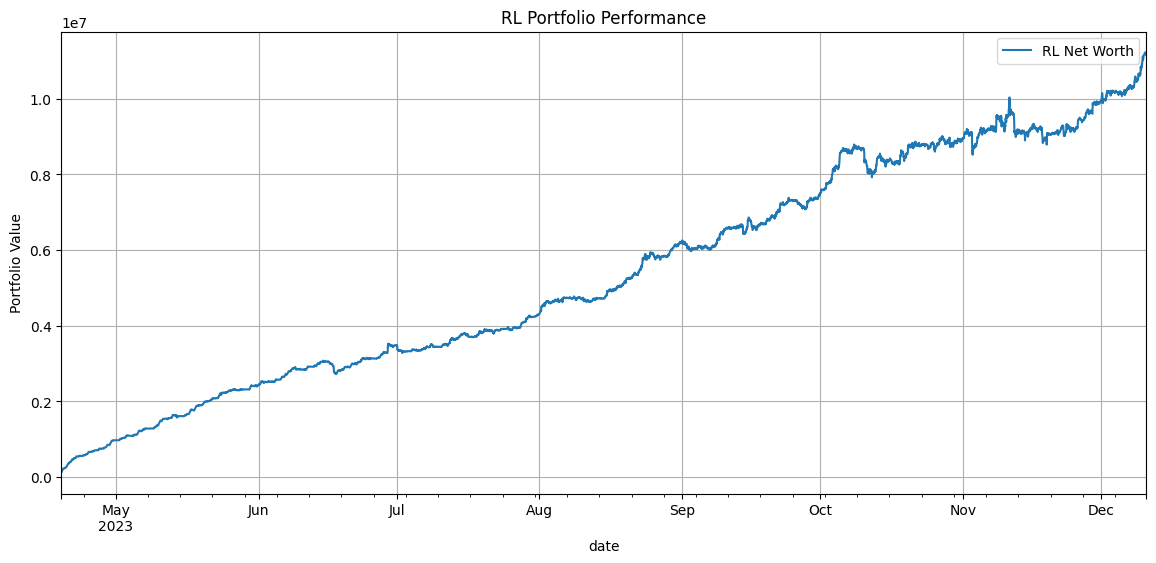

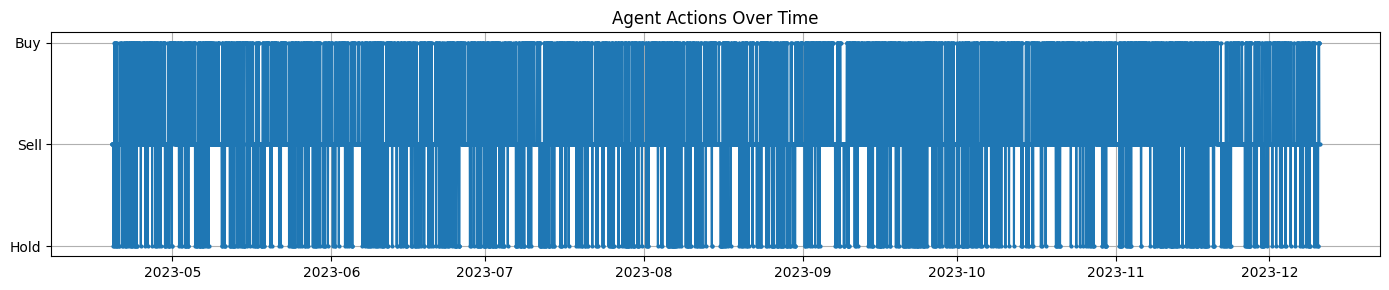

In [ ]:
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)

    env_info = info[0]
    current_step = env_info["current_step"]
    if 'timestamp' in df_test.columns and 0 <= current_step < len(df_test):
        date = df_test.iloc[current_step]['timestamp']
    else:
        date = current_step

    net_worths.append(env_info["net_worth"])
    balances.append(env_info["balance"])
    holdings.append(env_info["holdings"])
    actions.append(action[0])
    rewards.append(reward[0])
    dates.append(date)

# === Backtest Results ===
results = pd.DataFrame({
    "date": pd.to_datetime(dates),
    "net_worth": net_worths,
    "balance": balances,
    "holdings": holdings,
    "action": actions,
    "reward": rewards,
})
results.set_index("date", inplace=True)

results["returns"] = results["net_worth"].pct_change()
results.dropna(inplace=True)

initial_capital = results["net_worth"].iloc[0]
final_capital = results["net_worth"].iloc[-1]
total_return = final_capital / initial_capital - 1

# Duration
duration_hours = (results.index[-1] - results.index[0]).total_seconds() / 3600
duration_years = duration_hours / 8760
cagr = (final_capital / initial_capital) ** (1 / duration_years) - 1 if duration_years > 0 else 0

# Risk Metrics
volatility = results["returns"].std() * np.sqrt(365 * 24)
sharpe = results["returns"].mean() / (results["returns"].std() + 1e-8) * np.sqrt(365 * 24)

# Win Percentage and Profit Ratio
positive_trades = results[results["reward"] > 0]
negative_trades = results[results["reward"] < 0]
win_percentage = len(positive_trades) / (len(positive_trades) + len(negative_trades) + 1e-8) * 100
profit_ratio = positive_trades["reward"].mean() / (abs(negative_trades["reward"].mean()) + 1e-8)

benchmark_returns = df_test["close"].pct_change().iloc[1500:].values  # or adjust based on `frame_bound`
strategy_returns = results["returns"].values
if len(benchmark_returns) == len(strategy_returns):
    beta = np.cov(strategy_returns, benchmark_returns)[0, 1] / (np.var(benchmark_returns) + 1e-8)
    alpha = (strategy_returns.mean() - beta * benchmark_returns.mean()) * 365 * 24
else:
    alpha, beta = np.nan, np.nan  # length mismatch fallback

# Sortino Ratio
risk_free_rate = 0.05  # 5% annual
risk_free_hourly = (1 + risk_free_rate) ** (1 / (365 * 24)) - 1
excess_returns = results["returns"] - risk_free_hourly

# Downside returns only: zero out positive excess returns
downside_returns = excess_returns[excess_returns < 0]
if len(downside_returns) > 0:
    downside_std = downside_returns.std() * np.sqrt(365 * 24)
    sortino = excess_returns.mean() / (downside_std + 1e-8)
else:
    sortino = np.nan  # Not enough downside returns to compute

rolling_max = results["net_worth"].cummax()
drawdown = (results["net_worth"] - rolling_max) / (rolling_max + 1e-8)
max_drawdown = drawdown.min()

# Calmar Ratio
calmar = cagr / abs(max_drawdown + 1e-8)

exposure_time_by_action = (results["action"] != 0).mean() * 100
exposure_time_by_holdings = (results["holdings"] > 0).mean() * 100

# Buy & Hold Benchmark
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'], format="%Y-%m-%d %H:%M:%S")
start_idx = 1500 - 24
end_idx = len(df_test) - 1
buy_price = df_test["close"].iloc[start_idx]
sell_price = df_test["close"].iloc[end_idx]
buy_and_hold_return = (sell_price - buy_price) / buy_price
buy_and_hold_years = (df_test["timestamp"].iloc[end_idx] - df_test["timestamp"].iloc[start_idx]).total_seconds() / (3600 * 24 * 365)
cagr_bh = (1 + buy_and_hold_return) ** (1 / buy_and_hold_years) - 1 if buy_and_hold_years > 0 else 0

# === Profit Percentage ===
num_profitable = len(positive_trades)
num_total_trades = len(positive_trades) + len(negative_trades)
profit_percentage = (num_profitable / (num_total_trades + 1e-8)) * 100

# === Summary ===
actions_series = results["action"]

print("\n Buy & Hold Benchmark")
print(f"Buy Price:           {buy_price:.2f}")
print(f"Sell Price:          {sell_price:.2f}")
print(f"Total Return:        {buy_and_hold_return * 100:.2f}%")
print(f"CAGR:                {cagr_bh * 100:.2f}%")

print("\n RL Strategy Backtest")
print(f"Initial Capital:     {initial_capital:.2f}")
print(f"Final Capital:       {final_capital:.2f}")
print(f"Total Return:        {total_return * 100:.2f}%")
print(f"CAGR:                {cagr * 100:.2f}%")
print(f"Profit Percentage:   {profit_percentage:.2f}%")
print(f"Exposure (Actions):  {exposure_time_by_action:.2f}%")
print(f"Exposure (Holdings): {exposure_time_by_holdings:.2f}%")
print(f"Annual Volatility:   {volatility * 100:.2f}%")
print(f"Sharpe Ratio:        {sharpe:.2f}")
print(f"Max Drawdown:        {max_drawdown * 100:.2f}%")
print(f"Sortino Ratio:       {sortino:.2f}")
print(f"Calmar Ratio:        {calmar:.2f}")
print(f"Win Percentage:      {win_percentage:.2f}%")
print(f"Profit Ratio:        {profit_ratio:.2f}")

print("\n Trade Actions")
print(f"Buy:                 {(actions_series == 2).sum()}")
print(f"Sell:                {(actions_series == 1).sum()}")
print(f"Hold:                {(actions_series == 0).sum()}")

# === Plot Net Worth ===
plt.figure(figsize=(14, 6))
results["net_worth"].plot(label="RL Net Worth")
plt.ylabel("Portfolio Value")
plt.title("RL Portfolio Performance")
plt.grid(True)
plt.legend()
plt.show()

# === Plot Actions ===
plt.figure(figsize=(14, 3))
plt.plot(results.index, results["action"], marker='o', linestyle='-', markersize=2)
plt.yticks([0, 1, 2], ['Hold', 'Sell', 'Buy'])
plt.title("Agent Actions Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
env.render()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:259: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")
